In [ ]:
###
### This Jupyter notebook contains functions and algorithms for the reanalysis of IBBCEAS data as measured in the Irish Simulation Atmospheric Chamber
### Please refer to the corresponding CESfunctions file for the specific functions involved
###

In [1]:
import glob
import numpy as np
import scipy.signal as scs
import datetime as dt
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
import CESfunctionsIASC as cf

In [24]:
##### What METADATA do we need?
# Unprocessed data filenames
sample_matrix =r'D:\IASC_IBBCEAS_Reanalysis\data\NO3\20240221\Imeas2402211806.npy'
background_txt =  r'D:\IASC_IBBCEAS_Reanalysis\data\NO3\20240221\Ib2402211326.txt'#the background (blank) TXT matrix

##### Processed data filenames
##### Depending on the number of columns the Mfile has, the call function variables need to be changed in the cell below (see comment)#####
Mfile_name =r'D:\IASC_IBBCEAS_Reanalysis\data\NO3\20240221\M2402211806.txt' # the Mfile with all the data
Mfile_rep_name = r'M2402211806r.txt'# the new Mfile to create after reprocessing

##### Reference filenames
reference1_name = r'D:\IASC_IBBCEAS_Reanalysis\NO3_IASC_1.npy' # name of reference 1 NPY file
reference2_name = r'D:\IASC_IBBCEAS_Reanalysis\NO2_IASC_3.npy'# name of reference 2 NPY file
#reference3_name = # name of reference 3 NPY file (optional, if needed by the cavity, e.g. NO3 uses NO3, NO2 and H2O)

##### Cavity and spectra parameters
lower_wavelength,upper_wavelength,distance=(650,672,500)
Reff = 0.999925 # a number if constant, np.load('Reff.npy') if a vector
#Reff = Reff.reshape(len(Reff),1) # uncomment this only if Reff is a vector
dfactor = 1 #the dilution factor is always 1 at IASC
start_avg = 1#from which background number to start averaging

In [9]:
##### File loading
samples = np.load(sample_matrix)
background = np.loadtxt(background_txt)
dateM,ppb1M,dum1,dum2= cf.Mfile_read(Mfile_name) #change number of variables as needed
reference1=np.load(reference1_name)
reference2=np.load(reference2_name)
#reference3=np.load(reference3_name) #uncomment if needed


In [11]:
##### Cutting sprectra, defining I_sample and I_0
minwave,maxwave=cf.segment_indices(samples,lower_wavelength,upper_wavelength)
sample=np.copy(samples[minwave:maxwave,:])
bckg=np.copy(background[minwave:maxwave,:])
ref1=np.copy(reference1[minwave:maxwave,:])
ref2=np.copy(reference2[minwave:maxwave,:])
#ref3=np.copy(reference3[minwave:maxwave,:]) #uncomment if needed
I_0 = np.average(bckg[:,start_avg:],axis=1).reshape(len(bckg),1)

In [12]:
#### Option 1: Look and analyze individual files

In [ ]:
sample_n=10 #number of the sample you want to analyze (can be identified in the Mfile by timestamp, line+1)
I_sample = sample[sample_n].reshape(len(sample),1)

pPa = 101335 # 1Atm +10
tK = 293.15 #20C

### fit_alg_1x_it (x=A,B,C) is the fitting algorithm with iteration of the SVD for 1,2,and 3 references, respectively
#alpha,fl,a,b,ndensity1 = cf.fit_alg_1A_it(I_sample, I_0, Reff, distance,ref1,pPa,tK,parameters=1)
alpha,fl,a,b,ndensity1,ndensity2 = cf.fit_alg_1B_it(I_sample, I_0, Reff, distance,ref1,ref2,pPa,tK,parameters=1)
#alpha,fl,a,b,ndensity1,ndensity2,ndensity3 = cf.fit_alg_1C_it(I_sample, I_0, Reff, distance,ref1,ref2,ref3,pPa,tK,parameters=1)

###
conc = (ndensity1*1e15*1.380649e-23*tK/pPa)
conc2 = (ndensity2*1e15*1.380649e-23*tK/pPa)
#conc3 = (ndensity3*1e15*1.380649e-23*tK/pPa)

In [ ]:
#### Option 2: Reprocess the whole dataset

In [26]:
ppbs = []
ppbs2 = []
ppbs3 = []
meastime = []

for ii in range(len(ppb1M)):
    I_sample = sample[:,ii].reshape(len(sample),1)

    pPa = 101335 # 1Atm +10
    tK = 293.15 #20C

    ### fit_alg_1x_it (x=A,B,C) is the fitting algorithm with iteration of the SVD for 1,2,and 3 references, respectively
    #alpha,fl,a,b,ndensity1 = cf.fit_alg_1A_it(I_sample, I_0, Reff, distance,ref1,pPa,tK,parameters=1)
    alpha,fl,a,b,ndensity1,ndensity2 = cf.fit_alg_1B_it(I_sample, I_0, Reff, distance,ref1,ref2,pPa,tK,parameters=1)
    #alpha,fl,a,b,ndensity1,ndensity2,ndensity3 = cf.fit_alg_1C_it(I_sample, I_0, Reff, distance,ref1,ref2,ref3,pPa,tK,parameters=1)

    ###
    conc = (ndensity1*1e15*1.380649e-23*tK/pPa)
    conc2 = (ndensity2*1e15*1.380649e-23*tK/pPa)
    #conc3 = (ndensity3*1e15*1.380649e-23*tK/pPa)
    
    ppbs.append(conc)
    ppbs2.append(conc2)
    #ppbs3.append(conc3)
    meastime.append(dateM[ii].strftime('%Y/%m/%d-%H:%M:%S'))

np.savetxt(Mfile_rep_name,np.column_stack((meastime,ppbs,ppbs2)),fmt='%s') #save reprocessed M file add/remove columns as needed
    

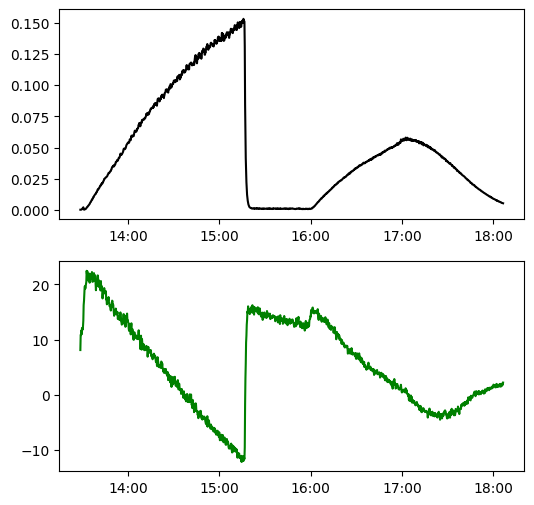

In [31]:
f= plt.figure(figsize=(6,6))
ax1 = f.add_subplot(211)
ax2 = f.add_subplot(212)
ax1.plot(dateM[10:],ppbs[10:],'-k')
ax2.plot(dateM[10:],ppbs2[10:],'-g')
ax1.xaxis.set_major_formatter(DateFormatter('%H:%M'))
ax2.xaxis.set_major_formatter(DateFormatter('%H:%M'))
plt.savefig('NO3_21Feb.png',facecolor='white')

In [22]:
meastime

['2024/02/21-13:26:26',
 '2024/02/21-13:26:39',
 '2024/02/21-13:26:52',
 '2024/02/21-13:27:05',
 '2024/02/21-13:27:18',
 '2024/02/21-13:27:31',
 '2024/02/21-13:27:45',
 '2024/02/21-13:27:58',
 '2024/02/21-13:28:11',
 '2024/02/21-13:28:24',
 '2024/02/21-13:28:37',
 '2024/02/21-13:28:50',
 '2024/02/21-13:29:03',
 '2024/02/21-13:29:16',
 '2024/02/21-13:29:29',
 '2024/02/21-13:29:42',
 '2024/02/21-13:29:55',
 '2024/02/21-13:30:08',
 '2024/02/21-13:30:21',
 '2024/02/21-13:30:34',
 '2024/02/21-13:30:47',
 '2024/02/21-13:31:01',
 '2024/02/21-13:31:14',
 '2024/02/21-13:31:27',
 '2024/02/21-13:31:40',
 '2024/02/21-13:31:53',
 '2024/02/21-13:32:06',
 '2024/02/21-13:32:19',
 '2024/02/21-13:32:32',
 '2024/02/21-13:32:45',
 '2024/02/21-13:32:58',
 '2024/02/21-13:33:11',
 '2024/02/21-13:33:24',
 '2024/02/21-13:33:37',
 '2024/02/21-13:33:50',
 '2024/02/21-13:34:04',
 '2024/02/21-13:34:17',
 '2024/02/21-13:34:30',
 '2024/02/21-13:34:43',
 '2024/02/21-13:34:56',
 '2024/02/21-13:35:09',
 '2024/02/21-13: